In [1]:
import tensorflow as tf
from src.dataset import dataset_tf
from src.audio import to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model
from src.plots import plot_history, plot_spectrograms

In [2]:
train_ds, val_ds, label_names = dataset_tf("./dataset/queenless")

Found 529 files belonging to 2 classes.
Using 424 files for training.
Using 105 files for validation.


2024-02-28 23:01:36.919436: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-02-28 23:01:36.919462: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-28 23:01:36.919473: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-28 23:01:36.919515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-28 23:01:36.919531: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


label names: ['no_queen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (32, 4000)
Example label shape: (32,)
513 44100
Label: no_queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

(118, 129, 1)


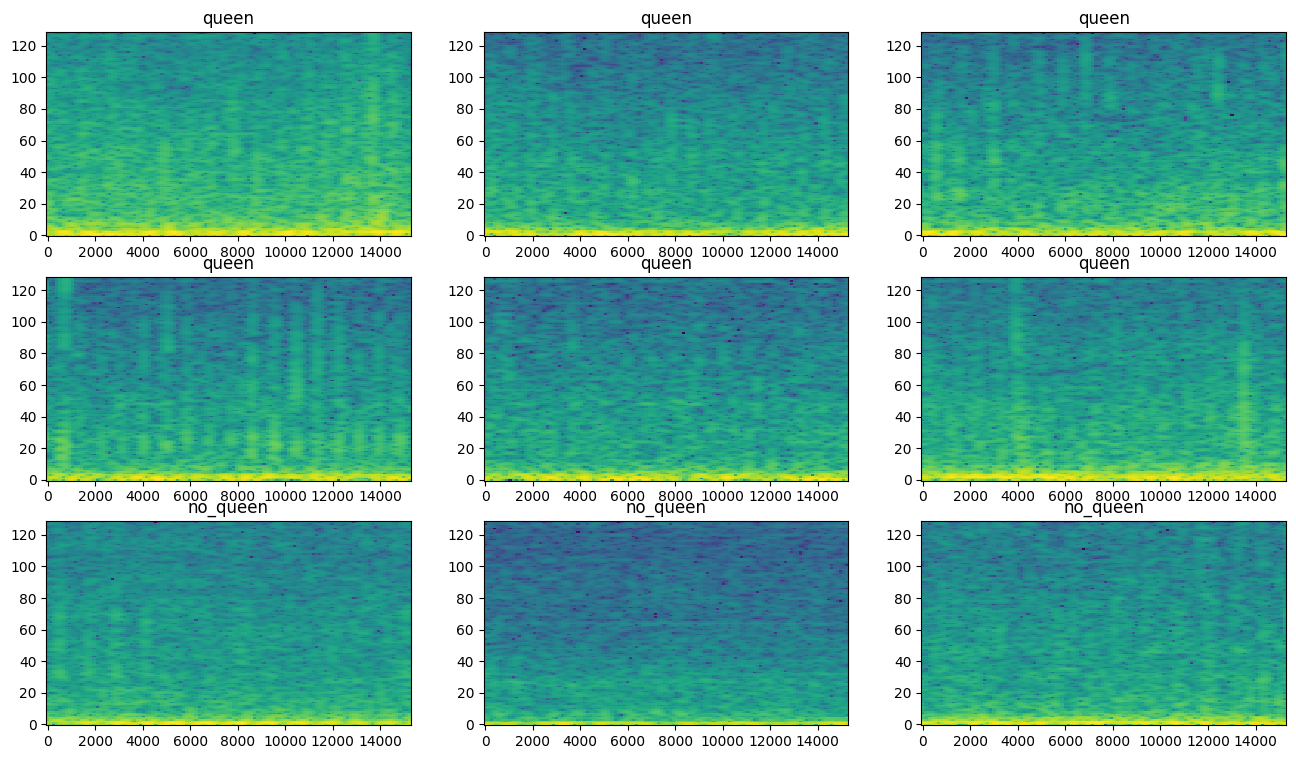

In [4]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [86]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [118]:
callbacks = list([
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, start_from_epoch=10),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, start_from_epoch=10),
    tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=6, start_from_epoch=10),
])

# Sequential model

In [119]:
model_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [120]:
history = model_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60
14/14 [==============================] - 1s 39ms/step - loss: 0.7385 - accuracy: 0.5401 - val_loss: 0.6124 - val_accuracy: 0.7048
Epoch 2/60
14/14 [==============================] - 0s 17ms/step - loss: 0.6300 - accuracy: 0.6887 - val_loss: 0.5677 - val_accuracy: 0.7714
Epoch 3/60
14/14 [==============================] - 0s 16ms/step - loss: 0.6013 - accuracy: 0.7406 - val_loss: 0.5232 - val_accuracy: 0.7905
Epoch 4/60
14/14 [==============================] - 0s 17ms/step - loss: 0.5500 - accuracy: 0.7712 - val_loss: 0.4639 - val_accuracy: 0.8571
Epoch 5/60
14/14 [==============================] - 0s 17ms/step - loss: 0.4468 - accuracy: 0.8137 - val_loss: 0.4030 - val_accuracy: 0.8476
Epoch 6/60
14/14 [==============================] - 0s 15ms/step - loss: 0.3861 - accuracy: 0.8349 - val_loss: 0.3517 - val_accuracy: 0.8381
Epoch 7/60
14/14 [==============================] - 0s 15ms/step - loss: 0.3593 - accuracy: 0.8467 - val_loss: 0.5768 - val_accuracy: 0.8095
Epoch 8/60
14

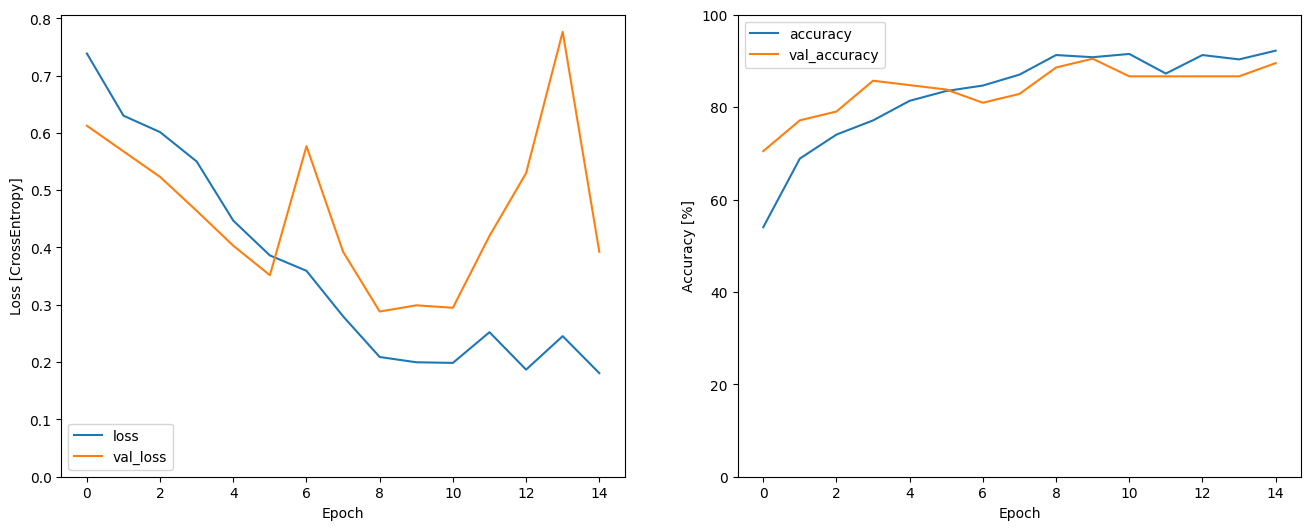

In [121]:
plot_history(history)

# Convolutional

In [122]:
model_conv = get_conv_model(input_shape, len(label_names))
model_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [123]:
history = model_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
14/14 [==============================] - 1s 34ms/step - loss: 0.8050 - accuracy: 0.5024 - val_loss: 0.7189 - val_accuracy: 0.4190
Epoch 2/50
14/14 [==============================] - 0s 24ms/step - loss: 0.7931 - accuracy: 0.3939 - val_loss: 0.7528 - val_accuracy: 0.4190
Epoch 3/50
14/14 [==============================] - 0s 20ms/step - loss: 0.6969 - accuracy: 0.5590 - val_loss: 0.6032 - val_accuracy: 0.6476
Epoch 4/50
14/14 [==============================] - 0s 17ms/step - loss: 0.6283 - accuracy: 0.7311 - val_loss: 0.5855 - val_accuracy: 0.7524
Epoch 5/50
14/14 [==============================] - 0s 21ms/step - loss: 0.6065 - accuracy: 0.7264 - val_loss: 0.5548 - val_accuracy: 0.8286
Epoch 6/50
14/14 [==============================] - 0s 22ms/step - loss: 0.5769 - accuracy: 0.7642 - val_loss: 0.5142 - val_accuracy: 0.7905
Epoch 7/50
14/14 [==============================] - 0s 18ms/step - loss: 0.5447 - accuracy: 0.7759 - val_loss: 0.4623 - val_accuracy: 0.8381
Epoch 8/50
14

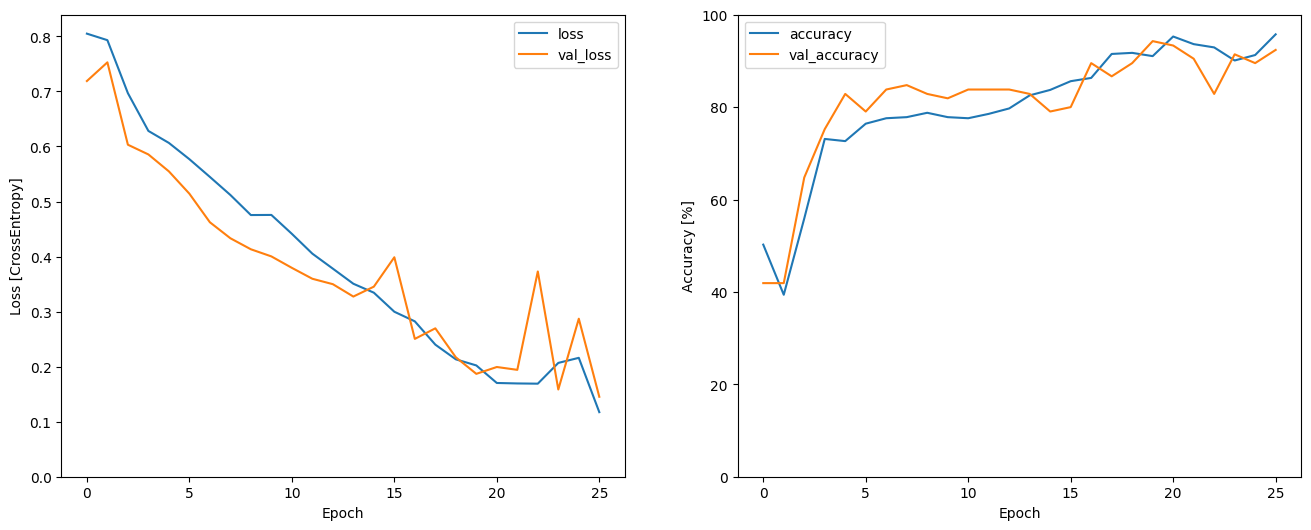

In [124]:
plot_history(history)